## Loading and preprocessing the datasets
In this section we are loading and preprocessing the datasets. Please note that some of the data we used are proprietary of US Bank and so we're not being able to make those datasets publicly available. In case you'd like to access those datasets please reach out to any of us. Our email ids can be found in the repository README.md file.

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the datasets
#HPI = pd.read_csv("USSTHPI.csv") # Quarterly HPI data
HPI_PO = pd.read_csv("data/HPI_Purchase_only_yoy_change.csv") # HPI Purchase Only data
EHS = pd.read_excel("data/Existing Home Sales.xlsx") # Existing Home Sales data, proprietary of US Bank.
StockQt = pd.read_excel("data/HousingStockWorksheet.xlsx", sheet_name = "Stock_Quarterly") # Housing Stock data, proprietary of US Bank.

In [3]:
# Chaging the column name and cleaning the HPI data
HPI_PO.DATE = pd.to_datetime(HPI_PO.DATE)
new_name = {'HPIPONM226S_PC1' : "HPA"}
HPI_PO.rename(columns=new_name, inplace= True)
HPI_PO.drop(HPI_PO.tail(1).index, inplace= True)
HPI_PO.HPA = HPI_PO.HPA.astype(float)

In [4]:
# Cleaning the quarterly housing stock data
StockQt.rename(columns={"Unnamed: 15" : "col 15", "Unnamed: 16" : "Eff_HS_US"}, inplace=True)
StockQt.drop(columns=["col 15"], inplace= True)
StockQt.dropna(subset=["Eff_HS_US"],inplace = True)
Quarters = StockQt.Quarter.values
Quarter_to_Date = {"Q1" : "-01-01",
                  "Q2" : "-04-01",
                  "Q3" : "-07-01",
                  "Q4" : "-10-01"}
Dates = []
for i in Quarters:
    y = i.split()[0]
    y+= Quarter_to_Date[i.split()[1]]
    Dates.append(y)
StockQt.Quarter = Dates

In [5]:
# Cleaning the existing home sells data
EHS.EOM = pd.to_datetime(EHS.EOM)
EHS.rename(columns= {"EOM" : "DATE"}, inplace = True)
EHS.dropna(subset=["Existing Home Sales"], inplace=True)
EHS["DATE"] = EHS.DATE.dt.to_period('Q')
EHS_Q = pd.DataFrame(EHS.groupby("DATE").mean())
EHS_Q.reset_index(inplace= True)
EHS_Q.drop(EHS_Q.tail(1).index,inplace=True)
EHS_Q["House_Stock"] = StockQt.Eff_HS_US.values
EHS_Q["Implied_Turnover"] = (EHS_Q["Existing Home Sales"]/(EHS_Q.House_Stock/1000))*100

In [6]:
# Calculating implied turnover and adding it as a column
Turnover = list(EHS_Q.Implied_Turnover.values)
Turnover = [np.nan]*(HPI_PO.shape[0]-len(Turnover))+Turnover
HPI_PO["Implied_Turnover"] = Turnover

In [7]:
# Loading and preprocessing the housing credit availability index (HCAI) dataset
HCAI = pd.read_csv("data/HCAI_WM.csv")
HCAI.rename(columns = {'Total\nRisk':'Total_Risk',
                       'Borrower\nRisk':'Borrower_Risk',
                       'Product\nRisk':'Product_Risk'}, inplace = True)
HCAI = HCAI[4:].reset_index(drop=True)
num_col = ['Total_Risk', 'Borrower_Risk', 'Product_Risk']
for col in num_col:
    HCAI[col] = HCAI[col].astype('float64')
HCAI_index = HCAI.index.to_list()
HCAI_Y = HCAI.Year.values
HCAI_Q = HCAI.Quarter.values
Quarter_to_Date = {1 : "-01-01", 2 : "-04-01",  3 : "-07-01", 4 : "-10-01"}
Dates = []
for i in HCAI_index:
    date = str(HCAI_Y[i])+Quarter_to_Date[HCAI_Q[i]]
    Dates.append(date)
HCAI['DATE'] = pd.to_datetime(Dates)
HCAI.drop(['Year', 'Quarter'], axis=1, inplace=True)

## Feature engineering

In this section we are performing some feature engineering and coming up with new features from the existing features. Then merging the datasets we prepared before to prepare the final dataset.

In [8]:
# Creating the final dataset merging previous two datasets we prepared
HPI_PO["HPA_MA_6"] = HPI_PO.HPA.rolling(6).mean()
for i in range(6):
    HPI_PO[f'HPA_Lag_{i+1}']= HPI_PO['HPA'].shift(i+1)
    
HPI_df = HPI_PO.dropna().reset_index(drop=True)
df_hpi_hcai = HPI_df.merge(HCAI, how='left')
df_hpi_hcai.drop(['Borrower_Risk', 'Product_Risk'], axis=1, inplace=True)
df_hpi_hcai.rename(columns={'Total_Risk':'HCAI'}, inplace = True)
df_hpi_hcai.fillna(method="ffill", inplace=True)

## Visualization


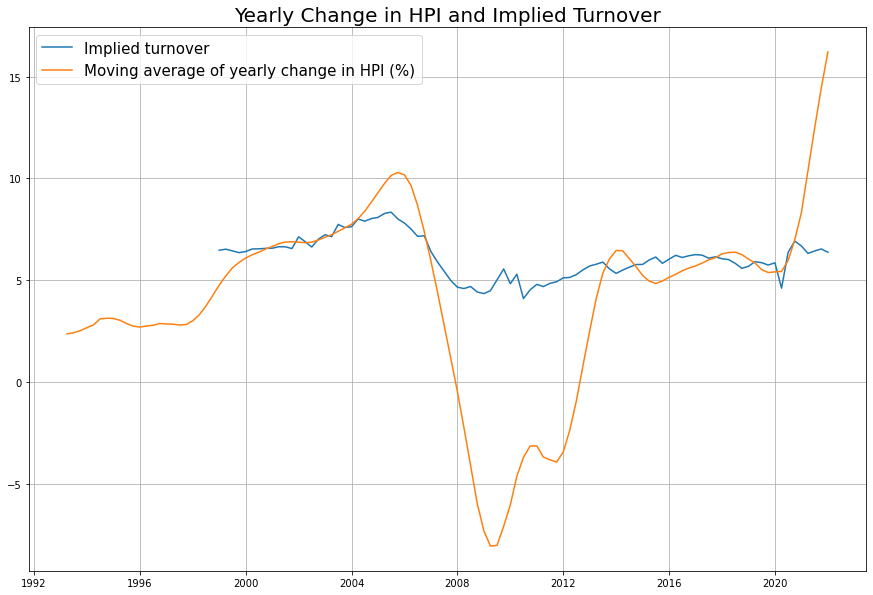

In [9]:
plt.figure(figsize=(15,10))
#plt.plot(HPI_PO.DATE, HPI_PO.YoY.values, label = "Yearly change in HPI (%)")
plt.plot(HPI_PO.DATE, HPI_PO.Implied_Turnover.values, label = "Implied turnover")
plt.plot(HPI_PO.DATE, HPI_PO.HPA_MA_6, label = "Moving average of yearly change in HPI (%)")
plt.legend(fontsize = 15)
plt.grid()
plt.title("Yearly Change in HPI and Implied Turnover", size = 20);

# **2. Train models**

Let us test each lag features.

In [10]:
df_hpi_hcai.columns

Index(['DATE', 'HPA', 'Implied_Turnover', 'HPA_MA_6', 'HPA_Lag_1', 'HPA_Lag_2',
       'HPA_Lag_3', 'HPA_Lag_4', 'HPA_Lag_5', 'HPA_Lag_6', 'HCAI'],
      dtype='object')

In [11]:
drop_fe = ['DATE', 'Implied_Turnover']
features = [col for col in list(df_hpi_hcai.columns) if col not in drop_fe]
features

['HPA',
 'HPA_MA_6',
 'HPA_Lag_1',
 'HPA_Lag_2',
 'HPA_Lag_3',
 'HPA_Lag_4',
 'HPA_Lag_5',
 'HPA_Lag_6',
 'HCAI']

In [12]:
df_hpi_hcai.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 0 to 92
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE              93 non-null     datetime64[ns]
 1   HPA               93 non-null     float64       
 2   Implied_Turnover  93 non-null     float64       
 3   HPA_MA_6          93 non-null     float64       
 4   HPA_Lag_1         93 non-null     float64       
 5   HPA_Lag_2         93 non-null     float64       
 6   HPA_Lag_3         93 non-null     float64       
 7   HPA_Lag_4         93 non-null     float64       
 8   HPA_Lag_5         93 non-null     float64       
 9   HPA_Lag_6         93 non-null     float64       
 10  HCAI              93 non-null     float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 8.7 KB


In [13]:
import statsmodels.api as sm
from scipy import stats

def test_features():
    for col in features:
        X = df_hpi_hcai[col]
        y = df_hpi_hcai['Implied_Turnover']
        X1 = sm.add_constant(X)
        print(f'========================== p-value table of {col} ==============================')
        print(sm.OLS(y,X1).fit().summary())
        print('=======================================================================================')

In [14]:
test_features()

========================== p-value table of HPA ==============================
                            OLS Regression Results                            
Dep. Variable:       Implied_Turnover   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     100.8
Date:                Fri, 05 Aug 2022   Prob (F-statistic):           2.12e-16
Time:                        21:39:08   Log-Likelihood:                -97.191
No. Observations:                  93   AIC:                             198.4
Df Residuals:                      91   BIC:                             203.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

Now, I decided to model 'Implied Turnover' by features 'YoY_HPI_MA_4' and 'HCAI'.

In [33]:
new_fea = ['HPA_MA_6', 'HCAI']

In [34]:
X = df_hpi_hcai[new_fea]
Y = df_hpi_hcai['Implied_Turnover']
X1 = sm.add_constant(X)
model = sm.OLS(Y, X1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Implied_Turnover   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     208.0
Date:                Wed, 27 Jul 2022   Prob (F-statistic):           1.79e-34
Time:                        22:44:29   Log-Likelihood:                -51.560
No. Observations:                  93   AIC:                             109.1
Df Residuals:                      90   BIC:                             116.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4577      0.110     40.378      0.0

#  **3. Forecast Covid period**

## **3.1 Time Series Cross-Validation**

In [35]:
covid_period = df_hpi_hcai[df_hpi_hcai['DATE']>='2020-01-01']
pre_covid = df_hpi_hcai[df_hpi_hcai['DATE']<'2020-01-01']

In [36]:
covid_period

,DATE,HPA,Implied_Turnover,HPA_MA_6,HPA_Lag_1,HPA_Lag_2,HPA_Lag_3,HPA_Lag_4,HPA_Lag_5,HPA_Lag_6,HCAI
84,2020-01-01,6.23889,5.860617,5.413953,5.52464,4.99680,5.08807,4.99882,5.63650,6.04784,5.300
85,2020-04-01,5.76118,4.613646,5.434733,6.23889,5.52464,4.99680,5.08807,4.99882,5.63650,5.137
86,2020-07-01,8.25959,6.377489,5.978195,5.76118,6.23889,5.52464,4.99680,5.08807,4.99882,4.989
87,2020-10-01,11.17118,6.925938,6.992047,8.25959,5.76118,6.23889,5.52464,4.99680,5.08807,5.082
88,2021-01-01,13.08681,6.684530,8.340382,11.17118,8.25959,5.76118,6.23889,5.52464,4.99680,5.125
89,2021-04-01,17.81826,6.321918,10.389318,13.08681,11.17118,8.25959,5.76118,6.23889,5.52464,5.145
90,2021-07-01,18.60512,6.440745,12.450357,17.81826,13.08681,11.17118,8.25959,5.76118,6.23889,5.169
91,2021-10-01,17.70045,6.539117,14.440235,18.60512,17.81826,13.08681,11.17118,8.25959,5.76118,5.169
92,2022-01-01,18.91433,6.382089,16.216025,17.70045,18.60512,17.81826,13.08681,11.17118,8.25959,5.169


In [37]:
pre_covid

,DATE,HPA,Implied_Turnover,HPA_MA_6,HPA_Lag_1,HPA_Lag_2,HPA_Lag_3,HPA_Lag_4,HPA_Lag_5,HPA_Lag_6,HCAI
0,1999-01-01,5.93694,6.477936,4.762640,5.70589,5.16140,4.52891,3.91376,3.32894,2.80875,11.236
1,1999-04-01,6.02527,6.529750,5.212028,5.93694,5.70589,5.16140,4.52891,3.91376,3.32894,11.790
2,1999-07-01,6.29097,6.447134,5.608230,6.02527,5.93694,5.70589,5.16140,4.52891,3.91376,13.209
3,1999-10-01,6.14804,6.359195,5.878085,6.29097,6.02527,5.93694,5.70589,5.16140,4.52891,14.332
4,2000-01-01,6.46462,6.412796,6.095288,6.14804,6.29097,6.02527,5.93694,5.70589,5.16140,14.764
...,...,...,...,...,...,...,...,...,...,...,...
79,2018-10-01,5.63650,5.589359,6.263820,6.04784,6.39748,6.95583,6.22040,6.32487,6.33621,5.861
80,2019-01-01,4.99882,5.688520,6.042812,5.63650,6.04784,6.39748,6.95583,6.22040,6.32487,5.981
81,2019-04-01,5.08807,5.915254,5.854090,4.99882,5.63650,6.04784,6.39748,6.95583,6.22040,5.805
82,2019-07-01,4.99680,5.866748,5.527585,5.08807,4.99882,5.63650,6.04784,6.39748,6.95583,5.515


In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

models = []
rmse = []
X, y = pre_covid[new_fea], pre_covid['Implied_Turnover']
tscv = TimeSeriesSplit(n_splits=6)
for fold, (train_index, test_index) in enumerate(tscv.split(pre_covid)):
    print(f'================== Fold {fold} =================')
    train_date = pre_covid.DATE.iloc[train_index].dt.date.values
    test_date = pre_covid.DATE.iloc[test_index].dt.date.values
    print(f'Train dataset from {train_date[0]} to {train_date[-1]}')
    print(f'Test dataset from {test_date[0]} to {test_date[-1]}')
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    models.append(model)
    predictions = model.predict(X_test)
    print(f'Fold {fold} has RSME: {np.sqrt(mean_squared_error(y_test, predictions))}')
    rmse.append(np.sqrt(mean_squared_error(y_test, predictions)))
print("RMSE: {}".format(np.mean(rmse)))

================== Fold 0 =================
Train dataset from 1999-01-01 to 2001-10-01
Test dataset from 2002-01-01 to 2004-10-01
Fold 0 has RSME: 0.8918784604362595
================== Fold 1 =================
Train dataset from 1999-01-01 to 2004-10-01
Test dataset from 2005-01-01 to 2007-10-01
Fold 1 has RSME: 0.5663961298589223
================== Fold 2 =================
Train dataset from 1999-01-01 to 2007-10-01
Test dataset from 2008-01-01 to 2010-10-01
Fold 2 has RSME: 2.6607673592104892
================== Fold 3 =================
Train dataset from 1999-01-01 to 2010-10-01
Test dataset from 2011-01-01 to 2013-10-01
Fold 3 has RSME: 0.22215316859638634
================== Fold 4 =================
Train dataset from 1999-01-01 to 2013-10-01
Test dataset from 2014-01-01 to 2016-10-01
Fold 4 has RSME: 0.30239154995310136
================== Fold 5 =================
Train dataset from 1999-01-01 to 2016-10-01
Test dataset from 2017-01-01 to 2019-10-01
Fold 5 has RSME: 0.1917133931613

The last fold has the lowest RMSE (Root mean squared error). So I decided to use all pre-covid data to train the model. 

In [39]:
X_covid = covid_period[new_fea]
y_pred_col = []
y_hist_col = []
for model in models:
    y_hist_col.append(model.predict(pre_covid[new_fea]))
    y_pred_col.append(model.predict(X_covid))
    y_pred = np.mean(y_pred_col,axis=0)
    y_hist = np.mean(y_hist_col, axis=0)
y_pred, y_hist

(array([6.20378133, 6.2012478 , 6.32166374, 6.56304928, 6.88041101,
        7.3606185 , 7.84383835, 8.30932324, 8.72472724]),
 array([6.32070949, 6.45096553, 6.60802066, 6.7220919 , 6.79249922,
        6.80234436, 6.80315287, 6.83454265, 6.84296109, 6.85519634,
        6.86236913, 6.85894509, 6.85912932, 6.85765792, 6.85655529,
        6.87469968, 6.91795353, 6.94415939, 6.97932238, 7.07971319,
        7.15797764, 7.22832002, 7.36624242, 7.46808262, 7.58561452,
        7.69846419, 7.77696469, 7.84830033, 7.84560662, 7.71445429,
        7.48560129, 7.19126187, 6.76209207, 6.23154463, 5.81180898,
        5.41988662, 4.95798612, 4.45587984, 4.02119811, 3.60071432,
        3.29244129, 3.10972407, 3.12820131, 3.36889784, 3.62337875,
        3.95753069, 4.16558041, 4.27885042, 4.27259159, 4.14051837,
        4.11408967, 4.09494171, 4.21128168, 4.45326523, 4.78304502,
        5.18649183, 5.55457105, 5.90851019, 6.18640174, 6.34870735,
        6.44177907, 6.43910327, 6.34887505, 6.26660579, 6.

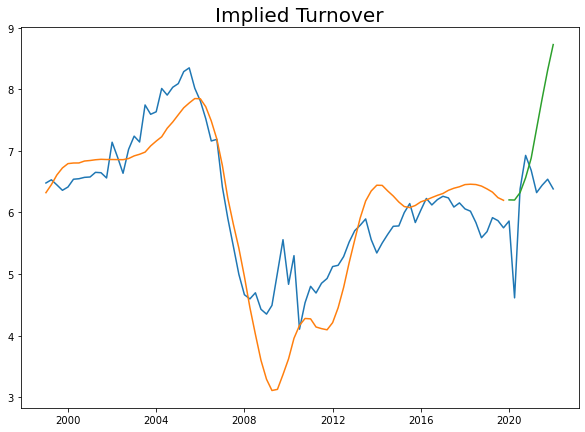

In [40]:
plt.figure(figsize=(10,7))
plt.plot(df_hpi_hcai.DATE, df_hpi_hcai.Implied_Turnover.values, label = "Implied turnover")
plt.plot(pre_covid.DATE, y_hist, label = "Fitted implied turnover")
plt.plot(covid_period.DATE, y_pred, label = "Predicted implied turnover")
#plt.legend(fontsize = 15)
plt.title("Implied Turnover", size = 20);

## **3.2 Using pre-covid period**

In [41]:
size = int(pre_covid.shape[0]*0.8)

In [42]:
size

67

In [43]:
train, test = pre_covid.iloc[:size,:], pre_covid.iloc[size:,:]

In [44]:
X_pre, y_pre = train[new_fea], train['Implied_Turnover']
X1_pre = sm.add_constant(X_pre)
model = sm.OLS(y_pre, X1_pre).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Implied_Turnover   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     200.4
Date:                Wed, 27 Jul 2022   Prob (F-statistic):           2.79e-28
Time:                        22:44:38   Log-Likelihood:                -37.785
No. Observations:                  67   AIC:                             81.57
Df Residuals:                      64   BIC:                             88.18
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3823      0.168     26.078      0.0

In [45]:
predictions = model.get_prediction(sm.add_constant(test[new_fea]))
pred_df = predictions.summary_frame(alpha=0.05)

In [46]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['Implied_Turnover'], pred_df['mean']))

0.23765606456048954

In [47]:
model_fit = model.predict(sm.add_constant(X_pre))

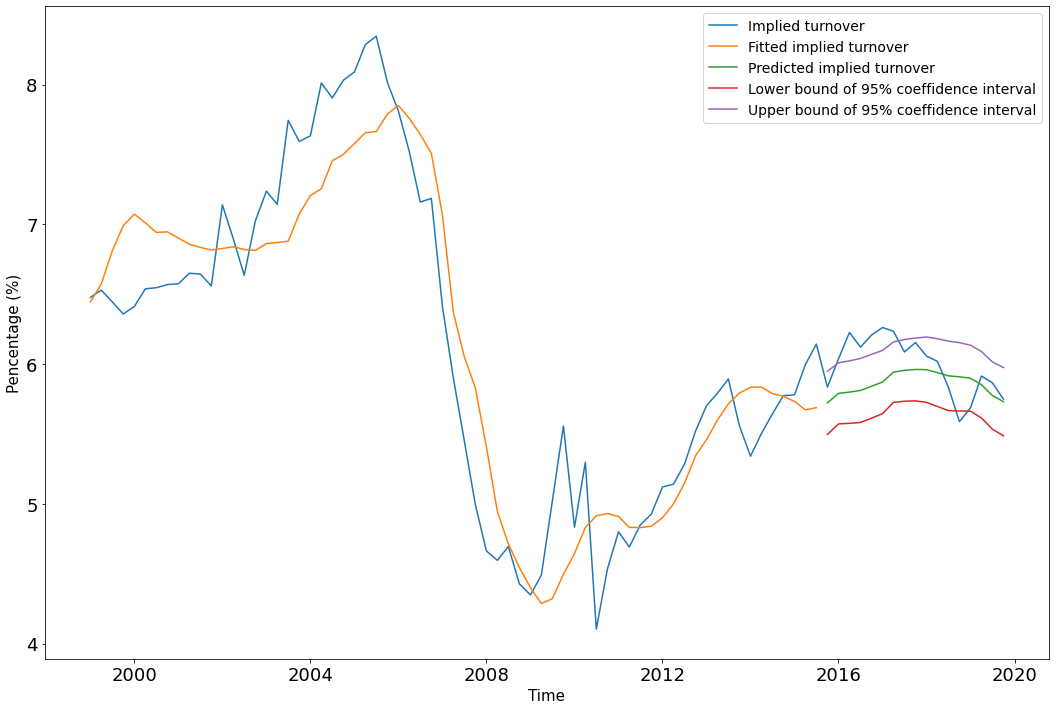

In [56]:
plt.figure(figsize=(18,12))
plt.plot(pre_covid.DATE, pre_covid.Implied_Turnover.values, label = "Implied turnover")
plt.plot(train.DATE, model_fit, label = "Fitted implied turnover")
plt.plot(test.DATE, pred_df['mean'], label = "Predicted implied turnover")
plt.plot(test.DATE, pred_df['mean_ci_lower'], label = "Lower bound of 95% coeffidence interval")
plt.plot(test.DATE, pred_df['mean_ci_upper'], label = "Upper bound of 95% coeffidence interval")
plt.legend(fontsize = 14)
plt.xticks(fontsize= 18)
plt.yticks(fontsize = 18)
#plt.title("Train and test model", size = 20);
plt.xlabel('Time', size = 15)
plt.ylabel('Pencentage (%)', size = 15)


ValueError: x and y must have same first dimension, but have shapes (9,) and (17,)

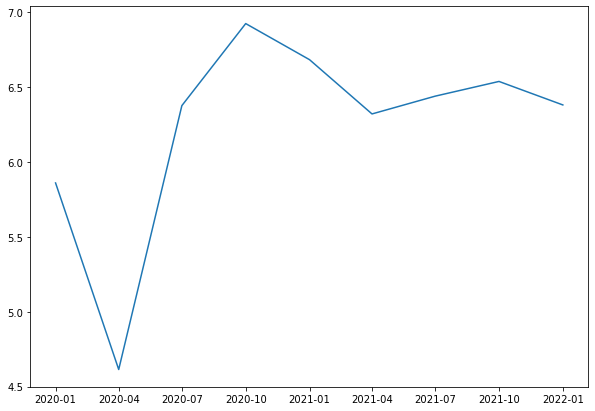

In [62]:
plt.figure(figsize=(10,7))
plt.plot(covid_period.DATE, covid_period.Implied_Turnover.values, label = "Implied turnover")
#plt.plot(pre_covid.DATE, pre_covid_fit, label = "Fitted implied turnover")
plt.plot(covid_period.DATE, pred_df['mean'], label = "Predicted implied turnover")
plt.plot(covid_period.DATE, pred_df['mean_ci_lower'], label = "Lower bound of 95% coeffidence interval")
plt.plot(covid_period.DATE, pred_df['mean_ci_upper'], label = "Upper bound of 95% coeffidence interval")
plt.legend(fontsize = 10)
plt.title("Single Model", size = 20);
plt.xlabel('Time', size = 17)
plt.ylabel('Pencentage (%)', size = 17)
ax = plt.gca()
ax.set_ylim([4.5, 8])

Let us see how is going with time series cross validation. 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import gc

models = []
rmse = []
X, y = pre_covid[new_fea], pre_covid['Implied_Turnover']
tscv = TimeSeriesSplit(n_splits=6)
for fold, (train_index, test_index) in enumerate(tscv.split(pre_covid)):
    print(f'========================== Fold {fold} ===========================')
    train_date = pre_covid.DATE.iloc[train_index].dt.date.values
    test_date = pre_covid.DATE.iloc[test_index].dt.date.values
    print(f'Train dataset from {train_date[0]} to {train_date[-1]}')
    print(f'Test dataset from {test_date[0]} to {test_date[-1]}')
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    X1_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X1_train).fit()
    models.append(model)
    predictions = model.predict(sm.add_constant(X_test))
    print(f'Fold {fold} has RMSE: {np.sqrt(mean_squared_error(y_test, predictions))}')
    rmse.append(np.sqrt(mean_squared_error(y_test, predictions)))
    del X_train, y_train, X_test, y_test, model
    gc.collect()
print("RMSE: {}".format(np.mean(rmse)))

In [ ]:
mean = []
upper = []
lower = []
hist = []
for model in models:
    predictions = model.get_prediction(sm.add_constant(covid_period[new_fea]))
    pred_df = predictions.summary_frame(alpha=0.05)
    fit = model.get_prediction(sm.add_constant(pre_covid[new_fea]))
    fit_df = fit.summary_frame(alpha=0.05)
    mean.append(pred_df['mean'])
    lower.append(pred_df['mean_ci_lower'])
    upper.append(pred_df['mean_ci_upper'])
    hist.append(fit_df['mean'])
pred = np.mean(mean, axis=0)
lower = np.mean(lower, axis=0)
upper = np.mean(upper, axis=0)
covid_mean = np.mean(hist, axis=0)

In [ ]:
np.sqrt(mean_squared_error(covid_period['Implied_Turnover'], pred))

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(covid_period.DATE, covid_period.Implied_Turnover.values, label = "Implied turnover")
#plt.plot(pre_covid.DATE, covid_mean, label = "Fitted implied turnover")
plt.plot(covid_period.DATE, pred, label = "Predicted implied turnover")
plt.plot(covid_period.DATE, lower, label = "Lower bound of 95% coeffidence interval")
plt.plot(covid_period.DATE, upper, label = "Upper bound of 95% coeffidence interval")
plt.legend(fontsize = 13)
plt.title("Implied Turnover", size = 20);
plt.xlabel('Time', size = 17)
plt.ylabel('Pencentage (%)', size = 17)
ax = plt.gca()
ax.set_ylim([4.5, 8])

# **4. Mobility rate**

In [ ]:
hor = pd.read_csv('HOR_Quarterly.csv')

In [ ]:
hor = hor[['Quarter', 'MOB']]

In [ ]:
df_hpi_hcai.head()

In [ ]:
hor['Quarter'] = pd.to_datetime(hor['Quarter'])

In [ ]:
hor.rename(columns={'Quarter':'DATE'}, inplace= True)

In [ ]:
hor['MOB_MA_6'] = hor.MOB.rolling(6).mean()
hor['MOB_Lag_6'] = hor.MOB.shift(6)

In [ ]:
hor.head()

In [ ]:
new_df =df_hpi_hcai.merge(hor, how='left', on='DATE')

In [ ]:
new_df.fillna(0, inplace=True)

In [ ]:
new_df.columns

In [ ]:
MOB_col = ['MOB_MA_6', 'MOB_Lag_6', 'MOB']
for col in MOB_col:
    features = ['HPA_MA_6', 'HCAI']
    features.append(col)
    X = new_df[features]
    Y = new_df['Implied_Turnover']
    X1 = sm.add_constant(X)
    model = sm.OLS(Y, X1).fit()
    print(model.summary())

# **Graph for final presentation**

In [53]:
pre_covid = df_hpi_hcai[df_hpi_hcai['DATE']<'2020-01-01'] #define covid period
size = int(pre_covid.shape[0]*0.8)  #define the size of train set
train, test = pre_covid.iloc[:size,:], pre_covid.iloc[size:,:] #split our dataset into 80% train set and 20% test set

In [54]:
X_pre, y_pre = train[new_fea], train['Implied_Turnover']
X1_pre = sm.add_constant(X_pre)
model = sm.OLS(y_pre, X1_pre).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Implied_Turnover   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     200.4
Date:                Wed, 27 Jul 2022   Prob (F-statistic):           2.79e-28
Time:                        16:31:13   Log-Likelihood:                -37.785
No. Observations:                  67   AIC:                             81.57
Df Residuals:                      64   BIC:                             88.18
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3823      0.168     26.078      0.0

In [55]:
predictions = model.get_prediction(sm.add_constant(test[new_fea]))
pred_df = predictions.summary_frame(alpha=0.05)

In [56]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['Implied_Turnover'], pred_df['mean']))

0.2376560645604896

In [57]:
model_fit = model.predict(sm.add_constant(X_pre))

Text(0, 0.5, 'Pencentage (%)')

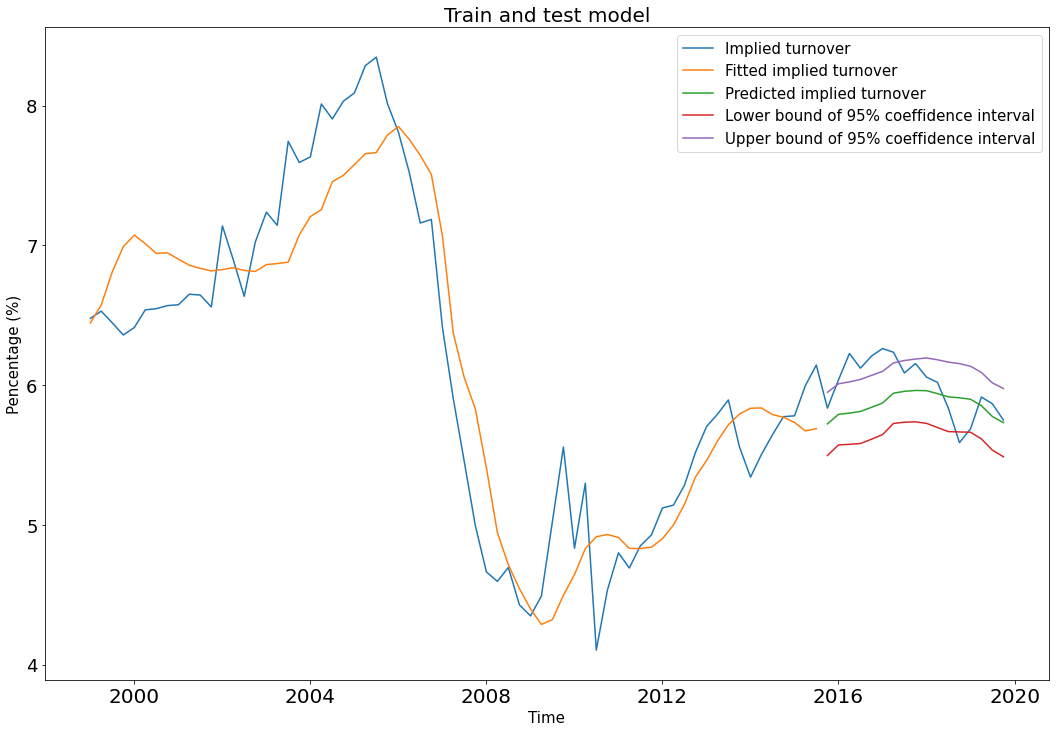

In [61]:
plt.figure(figsize=(18,12))
plt.plot(pre_covid.DATE, pre_covid.Implied_Turnover.values, label = "Implied turnover")
plt.plot(train.DATE, model_fit, label = "Fitted implied turnover")
plt.plot(test.DATE, pred_df['mean'], label = "Predicted implied turnover")
plt.plot(test.DATE, pred_df['mean_ci_lower'], label = "Lower bound of 95% coeffidence interval")
plt.plot(test.DATE, pred_df['mean_ci_upper'], label = "Upper bound of 95% coeffidence interval")
plt.legend(fontsize = 15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)
plt.title("Train and test model", size = 20);
plt.xlabel('Time', size = 15)
plt.ylabel('Pencentage (%)', size = 15)